In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import scanpy as sc 
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os, sys 
sys.path.append('../../src')

In [4]:
# import celloracle as co

In [5]:
# adata = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/snrna_human_tonsil.h5ad')
adata = sc.read_h5ad('/Users/koush/Desktop/training_data/snrna_human_tonsil.h5ad')
adata

AnnData object with n_obs × n_vars = 5778 × 3333
    obs: 'cell_type', 'author_cell_type', 'cell_type_int', 'banksy_celltypes'
    uns: 'cell_thresholds', 'cell_type_int_colors', 'received_ligands', 'received_ligands_tfl'
    obsm: 'spatial', 'spatial_unscaled'
    layers: 'imputed_count', 'normalized_count'

In [6]:
# plt.rcParams['figure.figsize'] = [5, 5]
# plt.rcParams['figure.dpi'] = 160
# sc.pl.embedding(adata, basis='spatial', 
#     color='cell_type', frameon=False, title='', 
#     legend_loc=None, size=60, add_outline=False, palette='tab20', 
#     outline_width=(0.2, 0.1), linewidth=0.2, edgecolor='black')

In [47]:
from spaceoracle.models.spatial_map import generate_grid_centers, distance
import numpy as np
from tqdm import tqdm
import random
from numba import jit

@jit(nopython=True)
def calculate_distances(random_point, centers, grid_size):
    dist_map = np.zeros((grid_size, grid_size))
    for i, center in enumerate(centers):
        u, v = divmod(i, grid_size)
        dist_map[u, v] = np.sqrt((random_point[0] - center[0])**2 + (random_point[1] - center[1])**2)
    return dist_map

@jit(nopython=True)
def normalize_maps(masked_distance_maps):
    n_cell_types, grid_size, _ = masked_distance_maps.shape
    normalized_maps = np.zeros_like(masked_distance_maps)
    
    for i in range(n_cell_types):
        min_val = np.inf
        max_val = -np.inf
        
        for u in range(grid_size):
            for v in range(grid_size):
                if masked_distance_maps[i, u, v] > 0:
                    min_val = min(min_val, masked_distance_maps[i, u, v])
                    max_val = max(max_val, masked_distance_maps[i, u, v])
        
        denominator = max(max_val - min_val, 1e-15)
        
        for u in range(grid_size):
            for v in range(grid_size):
                if masked_distance_maps[i, u, v] > 0:
                    normalized_maps[i, u, v] = (masked_distance_maps[i, u, v] - min_val) / denominator
    
    return normalized_maps

def generate_random_distance_map(coords_2d, cell_types, grid_size=64):
    """
    Generate a distance map from a random point with each channel masking a particular cell type.
    
    Args:
        coords_2d: 2D array of spatial coordinates (x, y)
        cell_types: Array of cell type labels corresponding to each coordinate
        grid_size: Size of the grid (default: 64x64)
    
    Returns:
        A distance map of shape (n_cell_types, grid_size, grid_size)
    """
    # Extract coordinates
    x, y = coords_2d[:, 0], coords_2d[:, 1]
    xmin, xmax, ymin, ymax = np.min(x), np.max(x), np.min(y), np.max(y)
    
    # Generate grid centers
    centers = generate_grid_centers(grid_size, grid_size, xmin, xmax, ymin, ymax)
    
    # Get unique cell types
    unique_cell_types = np.unique(cell_types)
    n_cell_types = len(unique_cell_types)
    
    # Choose a random point
    random_idx = random.randint(0, len(coords_2d) - 1)
    random_point = (coords_2d[random_idx, 0], coords_2d[random_idx, 1])
    
    # Create distance map using JIT-compiled function
    dist_map = calculate_distances(random_point, centers, grid_size)
    
    # Create masks for each cell type
    masks = np.zeros((n_cell_types, grid_size, grid_size))
    
    # Fill masks based on cell types
    for i, cell_type in enumerate(unique_cell_types):
        cell_indices = np.where(cell_types == cell_type)[0]
        for idx in cell_indices:
            x_coord, y_coord = coords_2d[idx]
            dist_to_centers = np.array([np.sqrt((x_coord - c[0])**2 + (y_coord - c[1])**2) for c in centers])
            nearest_center_idx = np.argmin(dist_to_centers)
            u, v = divmod(nearest_center_idx, grid_size)
            masks[i, u, v] = 1
    
    masked_distance_maps = np.zeros((n_cell_types, grid_size, grid_size))
    for i in range(n_cell_types):
        masked_distance_maps[i] = dist_map * masks[i]
    
    normalized_maps = normalize_maps(masked_distance_maps)
    
    return dist_map, normalized_maps


In [132]:
dist_map, normalized_maps = generate_random_distance_map(
    adata.obsm['spatial'], adata.obs.cell_type_major, grid_size=128)
dist_map.shape, normalized_maps.shape

((128, 128), (7, 128, 128))

In [79]:
import alphashape

adata.obs = adata.obs.join(pd.read_csv('tonsil_cell_types.csv', index_col=0))

adata.obs['cell_type_major'] = adata.obs.cell_type_2.replace(
    {
        'GC Dark Zone': 'Germinal Center B cells', 
        'GC Light Zone': 'Germinal Center B cells', 
        'GC Intermediate Zone': 'Germinal Center B cells', 
        'plasma': 'Plasma cells', 
        'B_naive': 'B cells', 
        'B_memory': 'B cells', 
        'B_germinal_center': 'Germinal Center B cells', 
        'Naive CD4 T': 'T cells', 
        'Treg': 'T cells', 
        'T memory': 'T cells', 
        'Th1': 'T cells', 
        'Th2': 'T cells', 
        'T_CD8': 'T cells', 
        'T_follicular_helper': 'T cells', 
        'mDC': 'Dendritic cells', 
        'FDC': 'Dendritic cells', 
        'myeloid': 'Myeloid cells', 
        'NK': 'NK cells', 
        'pDC': 'Dendritic cells', 
        'T_double_neg': 'T cells'
    }
)

ct_points_wt = {}
for ct in adata.obs['cell_type_major'].unique():
    points = np.asarray(
        adata[adata.obs['cell_type_major'] == ct].obsm['spatial'])
    delta = 30
    points = np.vstack(
        (points +[-delta,delta], points +[-delta,-delta], 
        points +[delta,delta], points +[delta,-delta]))
    ct_points_wt[ct] = points

alpha_shape = alphashape.alphashape(ct_points_wt['Germinal Center B cells'], alpha=0.035)



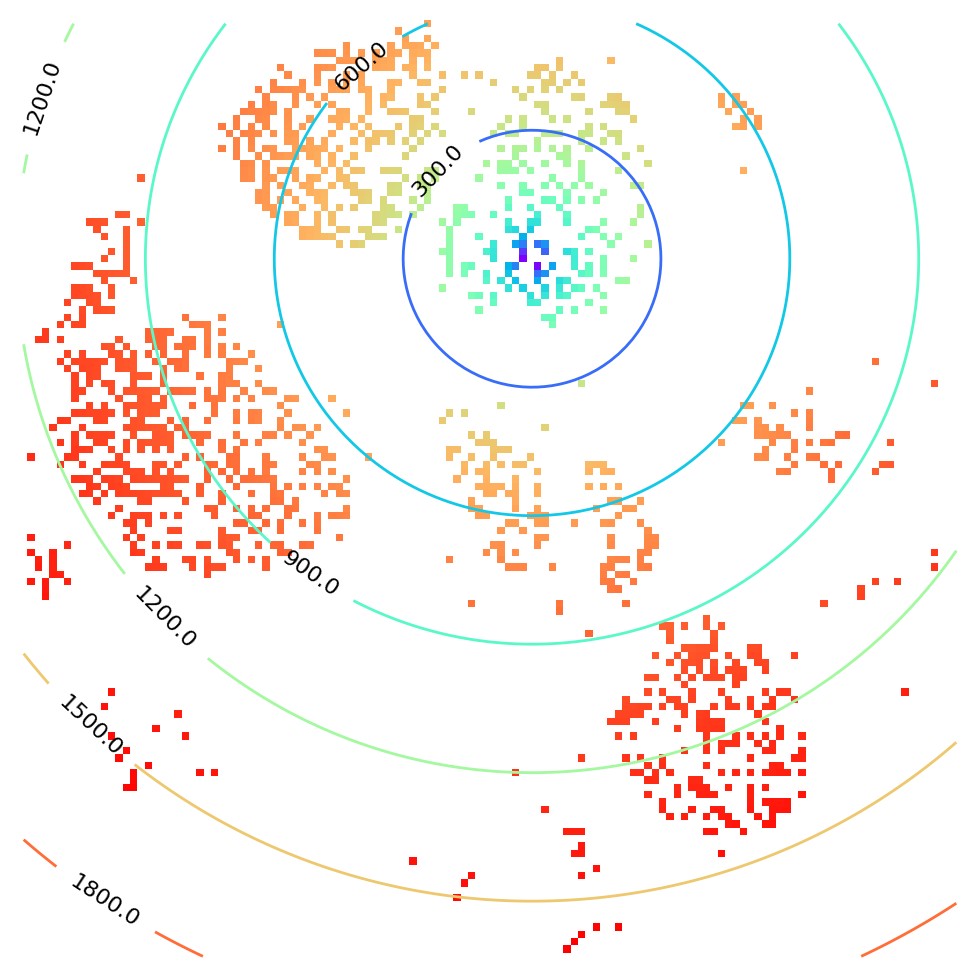

In [138]:
plt.rcParams['figure.figsize'] = [5, 5]
plt.rcParams['figure.dpi'] = 100

from matplotlib.colors import LogNorm, CenteredNorm, PowerNorm

plt.imshow(normalized_maps[2], cmap='rainbow', interpolation='none', norm=LogNorm())
contours = plt.contour(dist_map, levels=7, cmap='rainbow', linewidths=1)
plt.clabel(contours, inline=True, fontsize=8, fmt="%.1f", colors='black')
plt.axis('off')
plt.tight_layout()
plt.show()

In [6]:
from spaceoracle.tools.network import RegulatoryFactory
co_grn = RegulatoryFactory(
    # colinks_path='/ix/djishnu/shared/djishnu_kor11/training_data_2025/snrna_human_tonsil_colinks.pkl',
    colinks_path='/Users/koush/Desktop/training_data/snrna_human_tonsil_colinks.pkl',
    annot='cell_type_int'
)

In [7]:
from spaceoracle.models.parallel_estimators import SpatialCellularProgramsEstimator

estimator = SpatialCellularProgramsEstimator(
    adata, target_gene='PAX5', cluster_annot='cell_type_int',
    radius=400, contact_distance=50, grn=co_grn)

In [8]:
estimator.fit(
    num_epochs=20, 
    learning_rate=5e-3, 
    score_threshold=0.2,
    estimator='lasso'
)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Fitting PAX5 with 995 modulators
	19 Transcription Factors
	958 Ligand-Receptor Pairs
	18 TranscriptionFactor-Ligand Pairs
0: 0.8873 | 0.8904
1: 0.4072 | 0.4447
2: 0.8947 | 0.8963
3: 0.9916 | 0.9965
4: 0.6769 | 0.7121
5: 0.5574 | 0.5669
6: 0.9730 | 0.9715
7: 0.7344 | 0.8212
8: 0.8269 | 0.8423
9: 0.9035 | 0.9222
10: 0.9980 | 0.9984
11: 0.9809 | 0.9848
12: 0.9746 | 0.9794


In [24]:
betadata = estimator.betadata

In [35]:
estimator.train_df[['SMAD1', 'SOX9']]

,SMAD1,SOX9
NAME,,
AAACCCAAGCGCCTTG-1,0.029213,0.000000
AAACCCAAGTGGACGT-1,0.101690,0.004319
AAACCCACAGAAGTGC-1,0.023756,0.016586
AAACCCAGTCATTGCA-1,0.021847,0.000646
AAACCCATCATCGCAA-1,0.007771,0.000369
...,...,...
TTTGTTGCAGGGACTA-1,0.044012,0.003452
TTTGTTGCATTGTAGC-1,0.140092,0.000534
TTTGTTGGTACCACGC-1,0.069569,0.001041


['beta_IL4$IL4R',
 'beta_IL4$IL13RA1',
 'beta_IL4#EGR2',
 'beta_IL4#ERG',
 'beta_IL4#GLIS3',
 'beta_IL4#NR4A3',
 'beta_IL4#TCF7L2']

In [48]:
betadata[[i for i in betadata.columns if 'IL' in i and '$' in i]].join(estimator.adata.obs.cell_type).groupby(
    'cell_type').mean()

,beta_IL4$IL4R,beta_IL7$IL7R,beta_IL15$IL2RB,beta_IL4$IL13RA1,beta_IL6$IL6R,beta_IL6$IL6ST,beta_EBI3$IL27RA,beta_EBI3$IL6ST,beta_IL18$IL18R1,beta_IL18$IL18RAP,beta_IL33$IL1RAP,beta_IL34$CSF1R,beta_HLA-G$LILRB2
cell_type,,,,,,,,,,,,,
B memory,0.000000,0.000000,-0.044792,-0.000037,-0.001142,0.005375,0.011358,0.005166,-0.012901,-0.002193,0.001491,0.000000,0.0
B naive,0.008740,0.000000,0.000000,-0.000466,0.000000,0.001760,0.008953,-0.001294,-0.004691,0.000218,0.003283,-0.000358,0.0
CD4+ T,0.001843,-0.519587,-0.044622,0.000000,-0.000759,0.000393,-0.002803,-0.026032,-0.031784,-0.011276,-0.001473,0.000000,0.0
DC,0.010088,-0.304780,0.017162,0.000751,-0.016225,-0.027998,-0.031694,-0.147217,-0.334772,-0.007393,-0.004979,-0.009612,0.0
GC B,0.009088,0.000000,-0.002606,-0.000522,0.000000,0.000000,0.054314,0.000000,-0.000729,-0.000280,0.000000,0.000000,0.0
Macrophages,0.000682,0.020048,0.000008,0.000810,-0.001192,-0.001131,0.000000,0.009346,0.000008,0.000000,-0.001422,-0.002741,0.0
Plasma,0.009566,0.000000,0.016529,-0.000087,-0.006139,-0.006866,0.005738,-0.147408,-0.005666,-0.007990,0.000317,-0.000003,0.0
T cells,0.002333,-1.432863,-0.065362,0.001244,-0.005073,-0.003925,-0.020328,-0.019495,-0.064137,-0.044997,-0.001654,0.000000,0.0
Tfh,0.000000,-0.259885,0.006133,0.000163,-0.006090,-0.010608,-0.035781,-0.193373,0.024539,0.000000,0.002285,0.000000,0.0


In [10]:
# df = received_ligands(
#     adata.obsm['spatial'], 
#     get_ligands_df(adata.to_df(layer='imputed_count'), adata.obs['cell_thresholds'], estimator.ligands),
#     lr_info=estimator.lr 
# )

# df_nofilt = received_ligands(
#     adata.obsm['spatial'], 
#     get_ligands_df(adata.to_df(layer='imputed_count'), np.zeros(adata.n_obs), estimator.ligands),
#     lr_info=estimator.lr 
# )

# (df - df_nofilt).sum(axis=0)

In [16]:
from spaceoracle.prophets import Prophet
import anndata as ad
import pandas as pd
import matplotlib

In [18]:
betadata.to_parquet(f'/tmp/{estimator.target_gene}_betadata.parquet')

In [20]:
pythia = Prophet(
    adata=estimator.adata,
    models_dir='/tmp/',
    annot='cell_type_int',
)

Fitting ANKFN1 with 359 modulators
	31 Transcription Factors
	244 Ligand-Receptor Pairs
	84 TranscriptionFactor-Ligand Pairs
0: x.xxxx | 0.5970
1: x.xxxx | 0.5585
2: x.xxxx | 0.5236
3: 0.8538 | 0.8936
4: 0.4016 | 0.4938
5: x.xxxx | 0.8746
6: 0.3441 | 0.7796
7: 0.6364 | 0.9114
8: x.xxxx | 0.5877


In [ ]:
gex_df = estimator.adata.to_df(layer=estimator.layer)
pythia.compute_betas()
gene_mtx = pythia.adata.layers['imputed_count']
weighted_ligands = pythia._compute_weighted_ligands(gene_mtx)
beta_dict = pythia._get_wbetas_dict(
    pythia.beta_dict, weighted_ligands, gene_mtx)
wbetas = beta_dict.data[estimator.target_gene].wbetas
xy = beta_dict.xydf.copy()
xy.columns = ['x', 'y']
df = wbetas \
        .join(estimator.adata.obs) \
        .join(xy) \
        .join(gex_df)

In [ ]:
beta_cols_df = [i for i in df.columns if 'beta_' in i and i.replace('beta_', '') in np.unique(estimator.ligands)]

In [ ]:
beta_cols = [i for i in betadata.columns if 'beta_' in i and '$' in i]

In [ ]:
betadata[beta_cols].mean().sort_values(ascending=False)

In [ ]:
df[['beta_GAS6', 'beta_NPPC']].mean()

In [ ]:
# Create figure with 4 subplots in 2x2 layout
fig, axes = plt.subplots(2, 2, figsize=(14, 10), dpi=200)
axes = axes.flatten()

modulator = 'CCL21'

# Join data once for efficiency
plot_data = df[[f'beta_{modulator}', 'x', 'y', 'cell_type']].join(adata.to_df(layer='imputed_count'))

# Common plot settings
plot_settings = {
    'linewidth': 0.2,
    'edgecolor': 'black',
    's': 30
}

# Plot for cell_type
sns.scatterplot(
    data=plot_data,
    x='x',
    y='y', 
    hue='cell_type',
    palette='tab20',
    legend='brief',
    ax=axes[0],
    **plot_settings
)
axes[0].set_title('Cell Type', fontsize=14)
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot for modulator gene with colorbar
scatter1 = axes[1].scatter(
    plot_data['x'],
    plot_data['y'],
    c=plot_data[modulator],
    cmap='viridis',
    **plot_settings
)
axes[1].set_title(modulator, fontsize=14)
plt.colorbar(scatter1, ax=axes[1], shrink=0.5)

# Plot for target gene with colorbar  
scatter2 = axes[2].scatter(
    plot_data['x'],
    plot_data['y'],
    c=plot_data[estimator.target_gene], 
    cmap='magma',
    **plot_settings
)
axes[2].set_title(estimator.target_gene, fontsize=14)
plt.colorbar(scatter2, ax=axes[2], shrink=0.5)

# Plot for beta_modulator with colorbar
scatter3 = axes[3].scatter(
    plot_data['x'],
    plot_data['y'],
    c=plot_data[f'beta_{modulator}'],
    cmap='rainbow', 
    **plot_settings
)
axes[3].set_title(f'Beta {modulator}', fontsize=14)
plt.colorbar(scatter3, ax=axes[3], shrink=0.5)

# Remove ticks and set equal aspect for all axes
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_frame_on(False)

# Remove borders from legends
for ax in axes:
    legend = ax.get_legend()
    if legend is not None:
        legend.set_frame_on(False)

plt.tight_layout()
plt.show()

In [ ]:
import commot as ct

In [ ]:
df_ligrec = ct.pp.ligand_receptor_database(
        database='CellChat', 
        species='human', 
        signaling_type="Secreted Signaling"
    )
df_ligrec.columns = ['ligand', 'receptor', 'pathway', 'signaling']
          

In [ ]:
df_ligrec.query('ligand == "CCL21"')